In [4]:
#Cargando librerías 

from IPython.display import clear_output
import importlib

from PIL import Image
import matplotlib.pyplot as plt
import scipy as sp


import numpy as np
import pandas as pd
import os
import sys  

root = os.getcwd() + "/.."

sys.path.insert(0, root)

import src.positioning_sensors as ps
importlib.reload(ps)

import src.regionGrowing as rg
importlib.reload(rg)

import src.manageExperiments as me
importlib.reload(me)

import config.config as cfg
importlib.reload(cfg)


from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank

from skimage.draw import line


**Leyendo archivo de configuración del experimento**

In [5]:
fn = "linz_with_init_net_exp_2.txt"
me.createProject(fn)



Read File: ../experiments/linz_with_init_net_exp_2.txt
Creating Directory in: ../experiments/linz_experiment_with_initial_positions_no2/
Creating Directory ../experiments/linz_experiment_with_initial_positions_no2/results/
Creating Directory: ../experiments/linz_experiment_with_initial_positions_no2/semivariances/
Copy linz_with_init_net_exp_2.txt -> ../experiments/linz_experiment_with_initial_positions_no2/linz_with_init_net_exp_2.txt


**This function creates the following experiment structure where the semivariance maps and results are saved**
```
experiment/
├── linz_with_init_net_exp_2.txt
├── results
└── semivariances
```

In [6]:
setup = me.readConfigFile(fn)
for key in iter(setup):
    print(str(key)+":" ,setup[str(key)])

experiment_id: linz_experiment_with_initial_positions_no2/
folder_input: locations/linz/
folder_semivariances: semivariances/
folder_output: results/
input_ntli: world_atlas_linzn
input_evm: linz_prioridades
output_semivariances: semivariance050512022
output_values: optimum_values.csv
output_args: optimum_arguments.csv
desaturation_th: -1
neglect_values: -1
tolerance_distance: 0.5
tolerance_angle: 15
filterg_sx: 0.5
filterg_sy: 0.5
gaussian_mode: constant
init_fixed_net: [[39, 22], [35, 29], [34, 31], [34, 34], [36, 39]]
nsensors: [0, 1, 2, 3, 4, 5]
sensitivity_c: [1, 10, 20, 30, 40]
flatness_means_decrease: True
ga_params: {'max_num_iteration': 100, 'population_size': 2000, 'mutation_probability': 0.1, 'elit_ratio': 0.1, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': 500}


In [7]:
#this variable tells how to interpret a flat semivariance value, do we cut before of after the flat semivariance region 
flat_means_decrease = bool(setup['flatness_means_decrease'])
print(flat_means_decrease)

True


In [8]:
#cargamos imagenes en luminance e importance

img1 = cfg.data + setup["folder_input"] + setup["input_ntli"]
img2 = cfg.data + setup["folder_input"] + setup["input_evm"]

NTLI = np.array(Image.open(img1))
EVM = np.array(Image.open(img2))


In [9]:
#NTLI: luminance
NTLI = ps.readIMG(img1)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(img2, invert = True)


EAM = EAM/np.max(EAM)

# if saturation threshold is -1, then we do not apply desaturation
th = int(setup["desaturation_th"])

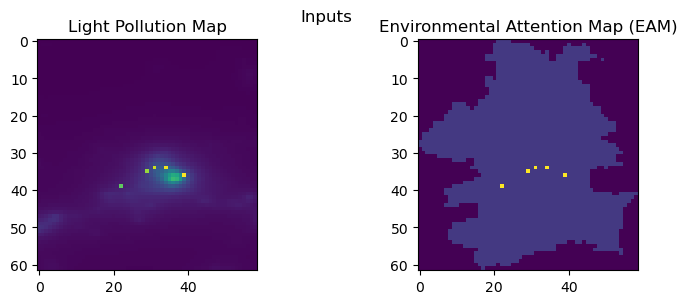

In [10]:
S = np.zeros(NTLI.shape)

for c in setup["init_fixed_net"]: 
    S[tuple(c)] = 5

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(NTLI+S)
plt.title("Light Pollution Map")
plt.subplot(122)
plt.imshow(EAM+S)
plt.title("Environmental Attention Map (EAM)")
plt.suptitle('Inputs')
plt.show()

**Smoothing Light pollution Map**

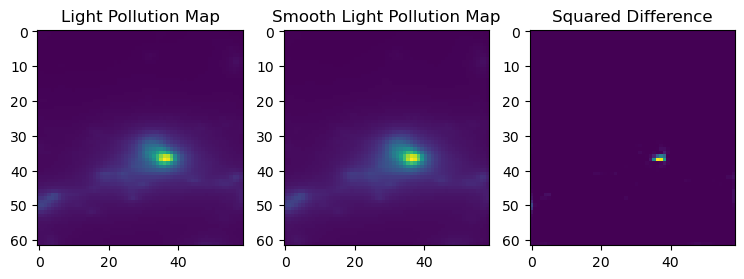

In [11]:
#loading smoothing parameters
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y, sigma_x]

FDNTLI = sp.ndimage.gaussian_filter(NTLI, sigma, mode = setup['gaussian_mode'])
nonsatc = np.copy(FDNTLI)


plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.imshow(NTLI)
plt.title("Light Pollution Map")
plt.subplot(132)
plt.imshow(FDNTLI)
plt.title("Smooth Light Pollution Map")
plt.subplot(133)
plt.imshow((NTLI-FDNTLI)**2)
plt.title("Squared Difference")

plt.show()

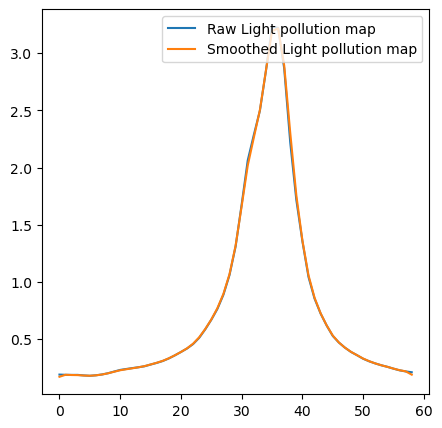

In [12]:

plt.figure(figsize=(5, 5))
plt.subplot(111)
plt.plot(NTLI[35,:], label = "Raw Light pollution map")
plt.plot(FDNTLI[35,:], label = "Smoothed Light pollution map")
plt.legend()
plt.show()

In [18]:
#fill the required params
#si = (28,19)

params = {"type": "semivar", 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(FDNTLI.shape)

#tell to the class, which object is going to be used to make the semivariogram

rG = rg.rGrowing(FDNTLI)

rG.setParams(params)

n = len(coords)

#ncords x imagesize m x n
image_size = (n, FDNTLI.shape[0]*FDNTLI.shape[1])
allsemivariances = np.zeros(image_size)
allmask = np.zeros(image_size)


df = pd.DataFrame()

In [19]:





coords = ps.get_coords(EAM==1)
n = len(coords)
for i, si in enumerate(coords):
    print("coords:", si)
    
    clear_output(wait = True)
    s = "{percen: 1.2f}%"
    print(s.format(percen = 100*(i + 1)/n))
    
    si = tuple(si)

    #generate a semivariance sv map
    sv = rG.makeSemivarianceMap(si)
    
    #flattne sv to store it in a dataframe
    allsemivariances[i] = sv.flatten()
    
    #construct a mask of sv and then flatten it
    allmask[i] = ps.constructMask(si, sv, flat_means_decrease).flatten()

 100.00%


In [257]:
#path to save collection of semivariances

prefix_path = (cfg.experiment + setup["experiment_id"] 
          + setup["folder_semivariances"] 
          + setup["output_semivariances"])


filesv = ( prefix_path + ".csv")

print("Semivariances saved at: ", filesv)

#path to save collection of masks
#each semivariance map is associated with a mask.
#mask defines the region of influence

filesvmask = (prefix_path + "mask.csv")

print("Semivariances mask saved to: ", filesvmask)

Semivariances saved at:  ../experiments/linz_experiment_with_initial_positions_no2/semivariances/semivariance050512022.csv
Semivariances mask saved to:  ../experiments/linz_experiment_with_initial_positions_no2/semivariances/semivariance050512022mask.csv


In [258]:


df_semivariance = pd.DataFrame(allsemivariances)
df_semivariance.insert(0, "coordsy", coords[:,0]) 
df_semivariance.insert(1, "coordsx", coords[:,1])
df_semivariance.to_csv(filesv)

df_semivariance_mask = pd.DataFrame(allmask)
df_semivariance_mask.insert(0, "coordsy", coords[:,0]) 
df_semivariance_mask.insert(1, "coordsx", coords[:,1])
df_semivariance_mask.to_csv(filesvmask)

```
linz_experiment_with_initial_positions_no2/
├── linz_with_init_net_exp_2.txt
├── results
└── semivariances
    ├── semivariance050512022.csv
    └── semivariance050512022mask.csv
```

(34, 34)


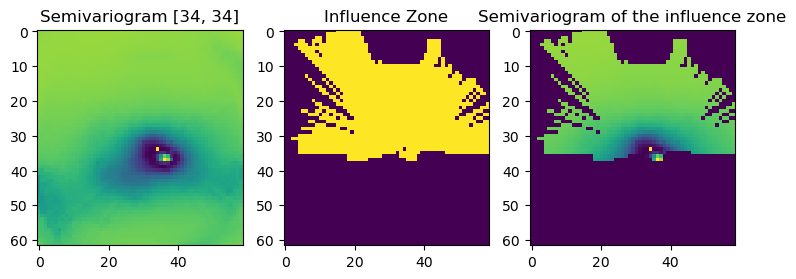

(34, 31)


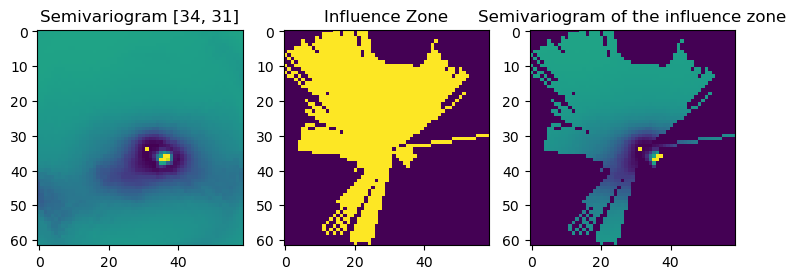

(35, 29)


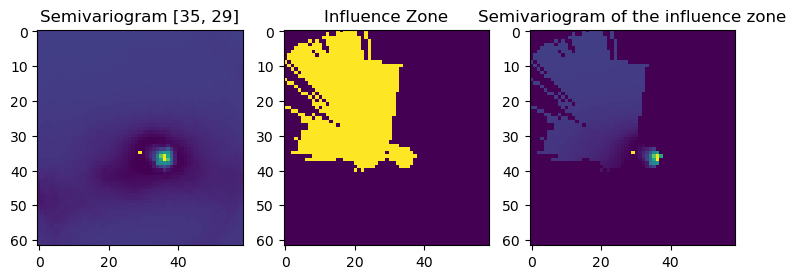

(36, 39)


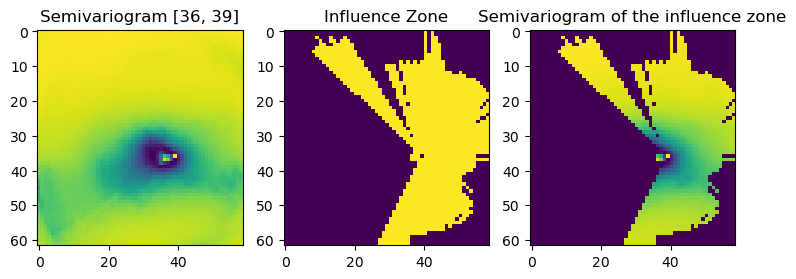

(39, 22)


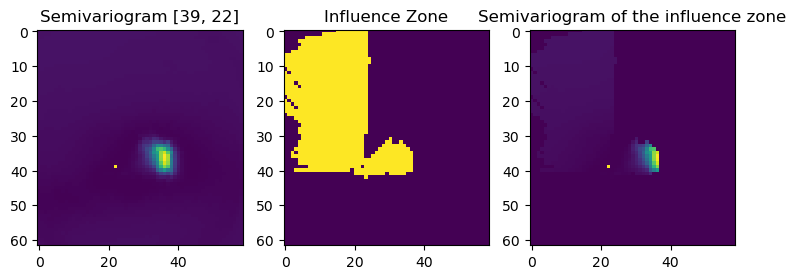

In [310]:
for si in setup["init_fixed_net"]:
    print(tuple(si))
    
    sv = rG.makeSemivarianceMap(tuple(si))
    sm = ps.constructMask(si, sv, flat_means_decrease)
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    sv[tuple(si)] = np.max(sv)
    plt.imshow(sv)
    plt.title("Semivariogram"+" "+str(si))
    plt.subplot(132)
    sm[tuple(si)] = np.min(sm)
    plt.imshow(sm)
    plt.title("Influence Zone")
    plt.subplot(133)
    smsv = sm*sv
    smsv[tuple(si)] = np.max(smsv)
    plt.imshow(smsv)
    plt.title("Semivariogram of the influence zone")
    plt.show()